### Imports

In [1]:
import h5py
import numba
import numpy as np
import pandas as pd
import scipy.integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
from hoki.utils.exceptions import HokiFormatError
from hoki.constants import BPASS_METALLICITIES, BPASS_NUM_METALLICITIES
from pylab import cm
from scipy.special import gammainc
from scipy.special import gamma

In [2]:
h = 0.6766

Colormap

In [3]:
BPASS_METALS = ["10$^{-5}$", "10$^{-4}$", "0.001", "0.002", "0.003", "0.004", "0.006", "0.008", "0.010", "0.014", "0.020", "0.030", "0.040"]

In [4]:
NUM_COLORS = len(BPASS_METALS)
cmap = plt.get_cmap('coolwarm')
bounds = np.linspace(0, NUM_COLORS, NUM_COLORS + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

### Data

In [5]:
file = h5py.File("/Users/dillon/Desktop/data.h5", "r")
SFH = file['SFH']['empirical']

In [6]:
NUM_COLORS = len(BPASS_METALS)
cmap = plt.get_cmap('coolwarm')
bounds = np.linspace(0, NUM_COLORS, NUM_COLORS + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [7]:
redshift_values = SFH.attrs['redshift']

Madau & Dickinson

In [8]:
M_D = 0.015 * (1 + redshift_values)**2.7 / (1 + ((1 + redshift_values) / 2.9)**5.6)

trans_M_D = 0.66 * M_D * (h/0.7)

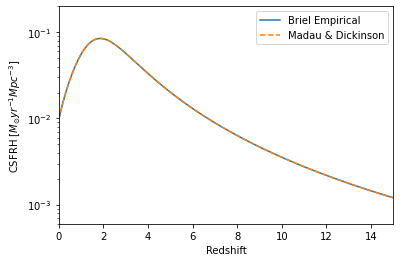

In [9]:
plt.plot(SFH.attrs['redshift'], np.sum(SFH, axis=0), label = 'Briel Empirical')
plt.plot(redshift_values, trans_M_D, '--', label = 'Madau & Dickinson')
plt.yscale('log')
plt.xlim(0, 15)
plt.ylim(6e-4, 2e-1)
plt.xlabel('Redshift')
plt.ylabel('CSFRH [$M_{\odot} yr^{-1} Mpc^{-3}$]')
plt.legend()

Langer & Norman Set Up

In [10]:
met_frac_list = np.array([0.0005, 0.005, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.5, 2])

In [11]:
ig_1 = 0.84

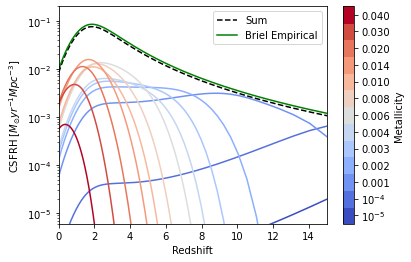

In [12]:
ln_eq_list = []


for met_frac in met_frac_list:
    ig_2 = met_frac**2 * 10**(0.3*redshift_values)
    ln_frac = gammainc(ig_1, ig_2)/gamma(0.84)
    ln_eq = trans_M_D * ln_frac
    ln_eq_list.append(ln_eq)



for i, met_frac in enumerate(met_frac_list):
    cumulative_contributions = ln_eq_list[i]
    for j in range(i):
        cumulative_contributions -= ln_eq_list[j]
    plt.plot(redshift_values, cumulative_contributions, color=cmap(norm(i)))


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.arange(NUM_COLORS) + 0.5, boundaries=bounds, label='Metallicity')
cbar.set_ticklabels(BPASS_METALS)

plt.plot(redshift_values, np.sum(ln_eq_list, axis=0), '--', color = 'black', label = 'Sum')    
plt.plot(SFH.attrs['redshift'], np.sum(SFH, axis=0), label = 'Briel Empirical', color = 'green')


plt.yscale('log')
plt.xlim(0, 15)
plt.ylim(6e-6, 2e-1)
plt.xlabel('Redshift')
plt.ylabel('CSFRH [$M_{\odot} yr^{-1} Mpc^{-3}$]')
plt.legend()

Briel

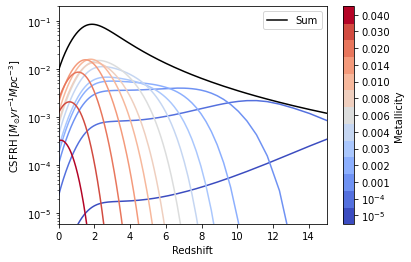

In [13]:
num_rows, num_columns = SFH.shape

for i in range(num_rows):
    plt.plot(redshift_values, SFH[i, :], color=cmap(norm(i)))
    
plt.plot(redshift_values, np.sum(SFH, axis=0), color = 'black', label = 'Sum')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.arange(NUM_COLORS) + 0.5, boundaries=bounds, label='Metallicity')
cbar.set_ticklabels(BPASS_METALS)

plt.xlabel('Redshift')
plt.ylabel('Values')
plt.yscale('log')
plt.xlim(0, 15)
plt.ylim(6e-6, 2e-1)
plt.xlabel('Redshift')
plt.ylabel('CSFRH [$M_{\odot} yr^{-1} Mpc^{-3}$]')
plt.legend()

No handles with labels found to put in legend.


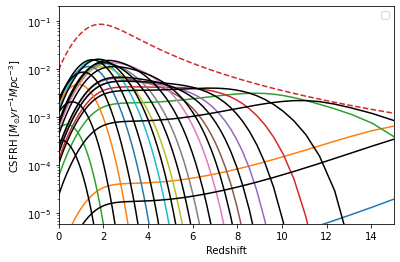

In [14]:
ln_eq_list = []


for met_frac in met_frac_list:
    ig_2 = met_frac**2 * 10**(0.3*redshift_values)
    ln_frac = gammainc(ig_1, ig_2)/gamma(0.84)
    ln_eq = trans_M_D * ln_frac
    ln_eq_list.append(ln_eq)


for i, met_frac in enumerate(met_frac_list):
    cumulative_contributions = ln_eq_list[i]
    for j in range(i):
        cumulative_contributions -= ln_eq_list[j]
    plt.plot(redshift_values, cumulative_contributions)
    

    
for i in range(num_rows):
    plt.plot(redshift_values, SFH[i, :], color = 'black')
    


plt.plot(SFH.attrs['redshift'], np.sum(SFH, axis=0), '--')    
plt.yscale('log')
plt.xlim(0, 15)
plt.ylim(6e-6, 2e-1)
plt.xlabel('Redshift')
plt.ylabel('CSFRH [$M_{\odot} yr^{-1} Mpc^{-3}$]')
plt.legend()

In the above, black is Briel

output_file_path = f'/Users/dillon/Desktop/split_output.h5'


with h5py.File(output_file_path, 'w') as file:
    dataset = file.create_dataset('star_form_hist', shape=(13, 500), dtype='<f8')

    dataset[:] = ln_eq_list
    
    dataset.attrs['redshift'] = redshift_values
